In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers

from google.cloud import storage

In [48]:
def train():
    # Read in the data
    bucket = 'rrusson-kubeflow-test'
    train_file = 'train_1247.329131066.csv'
    train_loc = "gs://{0}/{1}".format(bucket, train_file)
    train_data = pd.read_csv(train_loc, index_col=0)
    X_train = train_data.to_numpy()
    
    test_file = 'test_1247.329137254.csv'
    test_loc = "gs://{0}/{1}".format(bucket, test_file)
    test_data = pd.read_csv(test_loc, index_col=0)
    X_test = test_data.to_numpy()
    
    # reshape inputs for LSTM [samples, timesteps, features]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    print("Training data shape:", X_train.shape)
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print("Test data shape:", X_test.shape)   
    
    # define the model network for the autoencoder
    def autoencoder_model(X):
        inputs = Input(shape=(X.shape[1], X.shape[2]))
        L1 = LSTM(16, activation='relu', return_sequences=True, 
                  kernel_regularizer=regularizers.l2(0.00))(inputs)
        L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
        L3 = RepeatVector(X.shape[1])(L2)
        L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
        L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
        output = TimeDistributed(Dense(X.shape[2]))(L5)    
        model = Model(inputs=inputs, outputs=output)
        return model
    
    
    # create the autoencoder model
    model = autoencoder_model(X_train)
    model.compile(optimizer='adam', loss='mae')
    #model.summary()
    
    # fit the model to the data
    nb_epochs = 50
    batch_size = 10
    #history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
    #                    validation_split=0.1).history
    
    model = load_model("./model_v1.h5")
    history = pd.read_csv("./metrics.csv")
    
    # Evaluate the model
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()
    
    # plot the loss distribution of the training set
    X_pred = model.predict(X_train)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=train_data.columns)
    X_pred.index = train_data.index

    scored = pd.DataFrame(index=train_data.index)
    Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
    plt.figure(figsize=(16,9), dpi=80)
    plt.title('Loss Distribution', fontsize=16)
    sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
    plt.xlim([0.0,.5])
    
    # calculate the loss on the test set
    X_pred = model.predict(X_test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_data.columns)
    X_pred.index = test_data.index

    scored = pd.DataFrame(index=test_data.index)
    Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
    scored['Threshold'] = 0.275
    #scored['Threshold'] = 1.05 * scored['Loss_mae'].max()  # Give a 5% buffer to the value
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    print(scored.head(100))
    
    # calculate the same metrics for the training set 
    # and merge all data in a single dataframe for plotting
    X_pred_train = model.predict(X_train)
    X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
    X_pred_train = pd.DataFrame(X_pred_train, columns=train_data.columns)
    X_pred_train.index = train_data.index

    scored_train = pd.DataFrame(index=train_data.index)
    scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
    
    scored = pd.concat([scored_train, scored])
    scored = scored.reset_index(drop=True)
    #scored['Threshold'] = 0.275
    scored['Threshold'] = 1.05 * scored_train['Loss_mae'].max()  # Give a 5% buffer to the value
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    
    # plot bearing failure time plot
    scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
    
    #model.save("./model_v1.h5")
    
    return history, scored

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


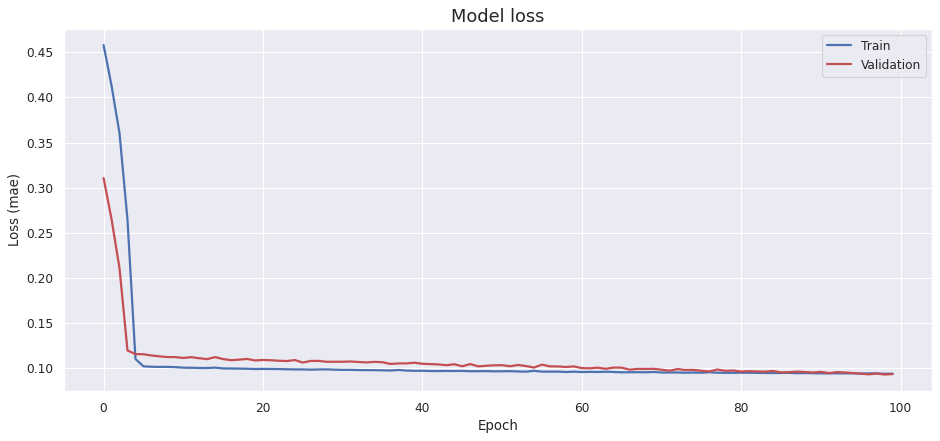

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


    Loss_mae  Threshold  Anomaly
0   0.128441      0.275    False
1   0.209319      0.275    False
2   0.091241      0.275    False
3   0.056958      0.275    False
4   0.071145      0.275    False
..       ...        ...      ...
95  0.391857      0.275     True
96  0.398657      0.275     True
97  0.479645      0.275     True
98  0.447324      0.275     True
99  0.560664      0.275     True

[100 rows x 3 columns]


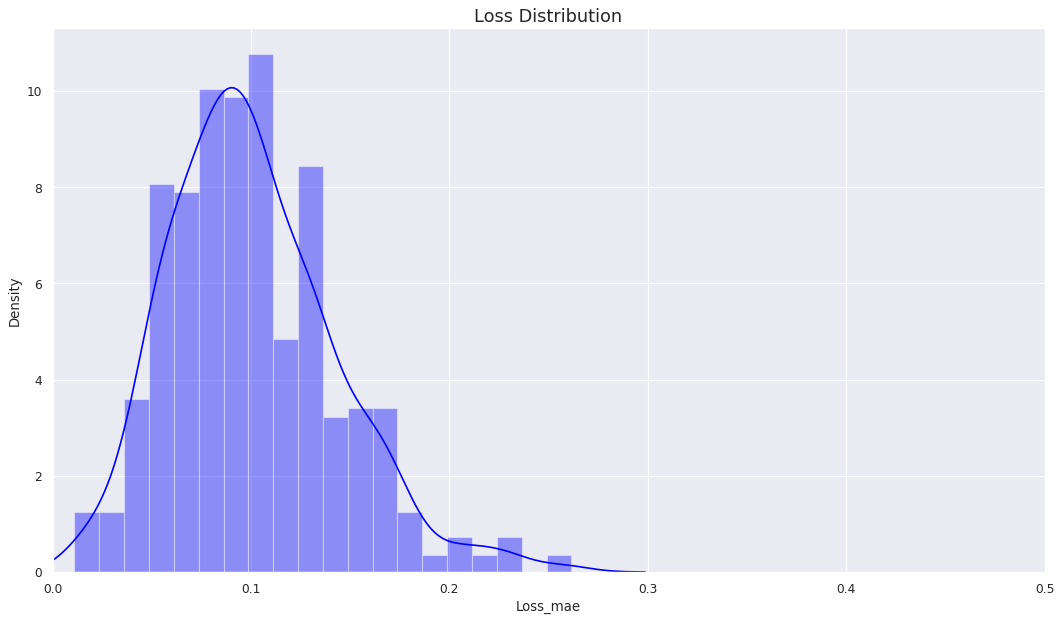

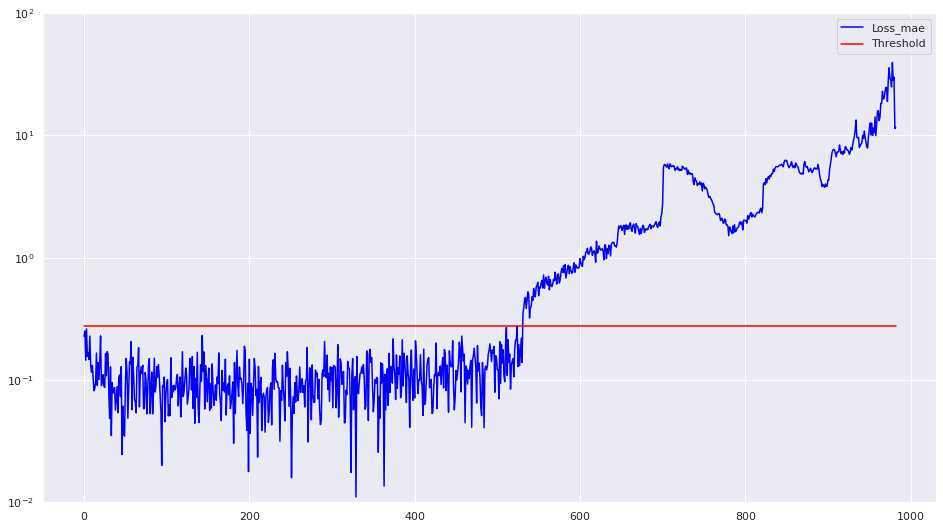

In [49]:
model_history, scored = train()

In [4]:
scored['Loss_mae'].sort_values()

329    0.011053
329    0.011053
363    0.013575
363    0.013575
251    0.015874
         ...   
143    0.231294
1      0.251516
1      0.251516
3      0.261543
3      0.261543
Name: Loss_mae, Length: 890, dtype: float64

In [5]:
scored['Loss_mae'].max()

0.26154303336492424

In [6]:
scored['Loss_mae'].mean()

0.1006189049687241

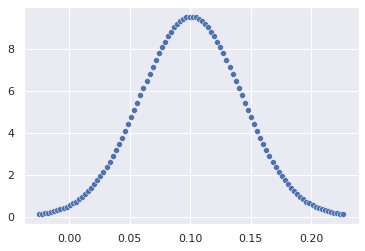

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = scored['Loss_mae'].mean()
variance = scored['Loss_mae'].var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
sns.scatterplot(x=x, y=stats.norm.pdf(x, mu, sigma))
plt.show()